In this tutorial we will demonstrate lithography integration on a ysplitter.

The tutorial will use the DUV model in UBC servers. Please make sure you can connect to UBC EECE servers. If not, replace 'DUV' with 'PreFab' and ensure that PreFab is installed, although the lithography effect wont be as pronounced.

In [1]:
import os, sys
sys.path.append('../../')
from config import Config
sys.path.append(Config.LUMERICAL_API_PATH) # if this fails adjust the config.py and add the lumerical api path

import numpy as np
import scipy as sp

import lumapi
from lumopt.utilities.wavelengths import Wavelengths
import lumopt.utilities.wavelengths as w1
from lumopt.geometries.polygon import FunctionDefinedPolygon
from lumopt.utilities.materials import Material
from lumopt.figures_of_merit.modematch import ModeMatch
from lumopt.optimization import Optimization
from lumopt.geometries.geometry import Geometry
from lumopt_gl.geometries.geometry_gl import Geometry_GL
from lumopt.optimizers.generic_optimizers import ScipyOptimizers
from lumopt_gl.optimization import OptimizationGL
from lumopt_gl.utilities.lithography import LithographyOptimizer

CONFIGURATION FILE {'root': '/opt/lumerical/v242/api/python', 'lumapi': '/opt/lumerical/v242/api/python'}


/home/mustafa/miniconda3/envs/faid/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/mustafa/miniconda3/envs/faid/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [5]:
def optimizer2D(polygon, base_script, max_iter = 12):
    wavelengths = Wavelengths(start = 1500e-9, stop = 1600e-9, points = 11)

    fom = ModeMatch(monitor_name = 'fom',mode_number = 'fundamental mode', direction = 'Forward', 
                    target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1)

    optimizer = ScipyOptimizers(max_iter = 20, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

    opt = OptimizationGL(base_script=base_script, wavelengths = wavelengths, fom = fom, geometry = polygon, optimizer = optimizer, 
                       use_var_fdtd=True, store_all_simulations = False)
    return opt

def optimizer3D(polygon, base_script, max_iter = 40):
    wavelengths = Wavelengths(start = 1500e-9, stop = 1600e-9, points = 11)

    fom = ModeMatch(monitor_name = 'fom',mode_number = 'fundamental TE mode', direction = 'Forward', 
                    target_T_fwd = lambda wl: np.ones(wl.size), norm_p = 1) # for 3D, we need to specify TE/TM

    optimizer = ScipyOptimizers(max_iter = max_iter, method = 'L-BFGS-B', scaling_factor = 1e6, pgtol = 1e-5)

    opt = OptimizationGL(base_script=base_script, wavelengths = wavelengths, fom = fom, geometry = polygon, optimizer = optimizer, 
                       use_var_fdtd=False, store_all_simulations = False, GPU = True) # and set varFDTD to False. Set GPU to True if you have one.
    return opt

Import the ybranch and set poly_wg = True, so that the waveguides are included in the geometry. For lithography, all polygons in the simulation must be specified in the geometry object. 

In [3]:
from geometries.ybranch import ybranch_3D

ybranch_geo, base_script = ybranch_3D(num_params = 20, poly_wg = True)

opt = optimizer3D(ybranch_geo, base_script)  # or optimizer2D(ybranch_geo, base_script)


Accurate interface detection enabled


We will just run the optimizer normally first. 

Wavelength range of source object will be superseded by the global settings.


/opt/lumerical/v242/api/python/lumopt/utilities/plotter.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Running scipy optimizer
bounds = [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]]
start = [0.26666667 0.28333333 0.3        0.31666667 0.33333333 0.35
 0.36666667 0.38333333 0.4        0.41666667 0.43333333 0.45
 0.46666667 0.48333333 0.5        0.51666667 0.53333333 0.55
 0.56666667 0.58333333]
Making forward solve
Processing forward solve in sequence
FOM = 0.7094824926248482
Making adjoint solve
[2.66666667e-07 2.83333333e-07 3.00000000e-07 3.16666667e-07
 3.33333333e-07 3.50000000e-07 3.66666667e-07 3.83333333e-07
 4.00000000e-07 4.16666667e-07 4.33333333e-07 4.50000000e-07
 4.66666667e-07 4.83333333e-07 5.00000000e-07 5.16666667e-07
 5.33333333e-07 5.50000000e-07 5.66666667e-07 5.83333333e-07]
Processing adjoint solve in sequence
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
...........

(0.9594803901217498,
 array([3.98923006e-07, 2.73707863e-07, 2.89455436e-07, 2.48082243e-07,
        2.45217407e-07, 2.44909670e-07, 2.61939689e-07, 2.83453348e-07,
        2.30919063e-07, 5.63200570e-07, 5.79731436e-07, 6.14744251e-07,
        5.88962274e-07, 5.93843482e-07, 5.94119928e-07, 5.98462453e-07,
        6.21187817e-07, 6.08002881e-07, 6.07480500e-07, 4.77188356e-07]))

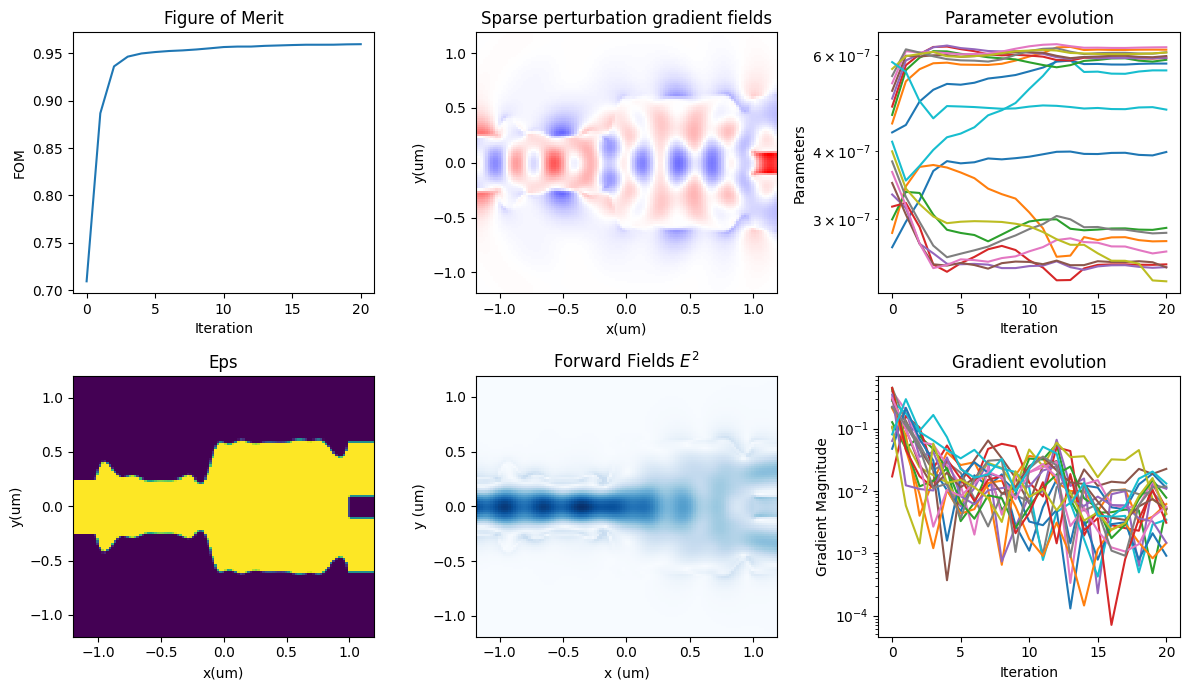

In [4]:
opt.run()

Now we will apply lithography model and run the forward simulation.

In [7]:
opt.geometry.lithography_model = LithographyOptimizer(model = 'NanoSOI')

Lets examine what the shape looks like before and after lithography.

Wavelength range of source object will be superseded by the global settings.


C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()
C:\Program Files/Lumerical/v232/api/python\lumopt\utilities\plotter.py:19: MatplotlibDeprecationWarning: 
The 'clear_temp' parameter of setup() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'clear_temp', they should be passed as keyword, not positionally.
  super().setup(fig, dpi, frame_prefix, clear_temp = False)


Running scipy optimizer
bounds = [[0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]
 [0.2 0.8]]
start = [0.26666667 0.28333333 0.3        0.31666667 0.33333333 0.35
 0.36666667 0.38333333 0.4        0.41666667 0.43333333 0.45
 0.46666667 0.48333333 0.5        0.51666667 0.53333333 0.55
 0.56666667 0.58333333]
Making forward solve
Making adjoint solve
[2.66666667e-07 2.83333333e-07 3.00000000e-07 3.16666667e-07
 3.33333333e-07 3.50000000e-07 3.66666667e-07 3.83333333e-07
 4.00000000e-07 4.16666667e-07 4.33333333e-07 4.50000000e-07
 4.66666667e-07 4.83333333e-07 5.00000000e-07 5.16666667e-07
 5.33333333e-07 5.50000000e-07 5.66666667e-07 5.83333333e-07]
Running solves
Processing forward solve
FOM = 0.7191655964457363
Processing adjoint solve
Calculating gradients
Getting d eps: dx = 2e-09
..............

KeyboardInterrupt: 

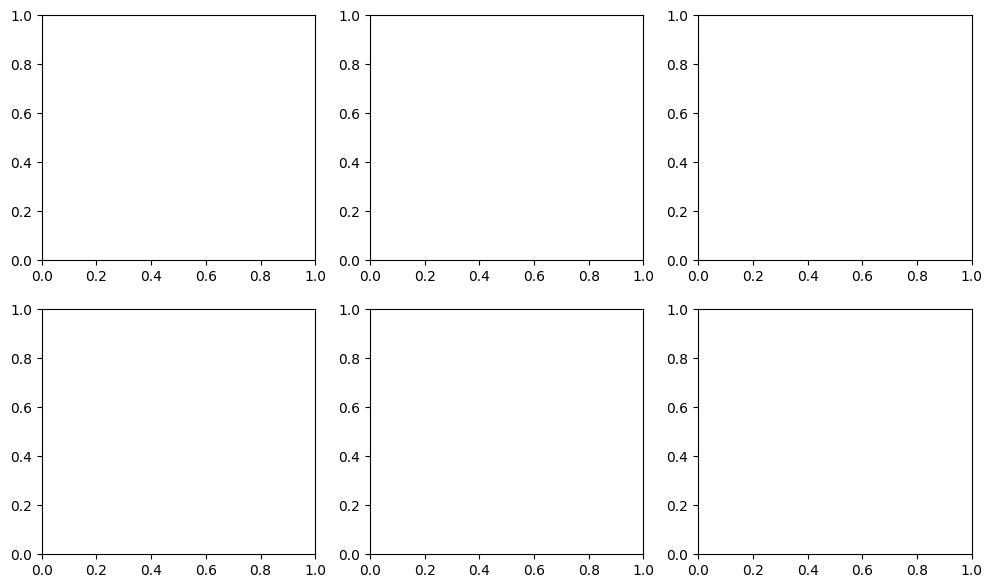

In [8]:
opt.run()

Now, we will create a new optimizer and integrate the lithography model.

In [6]:
opt2 = optimizer2D(ybranch_geo, base_script)
opt2.geometry.lithography_model = LithographyOptimizer(model = 'DUV')

Accurate interface detection enabled


In [1]:
opt2.run()

NameError: name 'opt2' is not defined

Finally, we will graph the lithography optimized ybranch and the original